In [1]:
%config Completer.use_jedi = False

import sys
sys.path.append('..')

import os
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

use_cpu = False
cuda_device = '0'

if use_cpu:
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
    os.environ['CPU_ONLY'] = "TRUE"
    physical_devices = tf.config.list_physical_devices('CPU')
    tf.config.set_logical_device_configuration(
        physical_devices[0],
        [tf.config.LogicalDeviceConfiguration() for i in range(8)])
    logical_devices = tf.config.list_logical_devices('CPU')

    print(logical_devices)
else:
    os.environ['CUDA_VISIBLE_DEVICES'] = cuda_device
    os.environ['CPU_ONLY'] = "FALSE"
    physical_devices = tf.config.list_physical_devices('GPU')
    print(physical_devices)
    
from collections import defaultdict
from sklearn.metrics import r2_score
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

from tndm.data import DataManager
from tndm import TNDM
from tndm.runtime import Runtime, ModelType
from tndm.utils import AdaptiveWeights
from tndm.models.model_loader import ModelLoader

from plotting import *

2021-10-25 04:30:19.346158: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2021-10-25 04:30:21.141060: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-25 04:30:21.142169: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-10-25 04:30:21.150530: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:03:00.0 name: GeForce RTX 2070 SUPER computeCapability: 7.5
coreClock: 1.77GHz coreCount: 40 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.29GiB/s
2021-10-25 04:30:21.150558: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-10-25 04:30:21.152650: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2021-10-25 04:30:21.152689: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10


In [2]:
# read the data
spike_data_dir = "/disk/scratch/cole/Chewie_CO_FF_2016-10-07_pos_M1_spikes/test_data/"

data_dir = os.path.join( spike_data_dir )

dataset, settings = DataManager.load_dataset(
    directory=data_dir,
    filename='dataset.h5')

# test set is combined valid and test
neural_data = dataset['train_data'].astype('float')
valid_neural_data = dataset['valid_data'].astype('float')
test_neural_data = dataset['test_data'].astype('float')

behavioural_data = dataset['train_behaviours'].astype('float')
valid_behavioural_data = dataset['valid_behaviours'].astype('float')
test_behavioural_data = dataset['test_behaviours'].astype('float')

# center behaviour at zero, using first time step (not strictly required)
b_mean = np.mean(np.vstack((behavioural_data, test_behavioural_data, valid_behavioural_data))[:,0,:],axis=0)
for i in range(2):
    behavioural_data[:,:,i] = behavioural_data[:,:,i]-b_mean[i]
    valid_behavioural_data[:,:,i] = valid_behavioural_data[:,:,i]-b_mean[i]
    test_behavioural_data[:,:,i] = test_behavioural_data[:,:,i]-b_mean[i]

# for plotting
d = dataset['train_target_direction']
direction_index_train = np.array([sorted(set(d)).index(i) for i in d])
d = dataset['test_target_direction']
direction_index_test = np.array([sorted(set(d)).index(i) for i in d])
direction_index_all = np.concatenate((direction_index_test, direction_index_train))

In [3]:
# model parameters

# l2 regulariser for the recurrent decoder weights
l2_reg = 1
initial_neural_weight = 1.0 # weight of neural nll
initial_behaviour_weight = .2 # weight of behaviour loss
lambda_q = 100.0
update_rate = .0005 
dropout = .15
seed = 0
GRU_pre_activation = False

optimizer = tf.keras.optimizers.Adam(
    learning_rate=1e-2,
    beta_1=0.9, 
    beta_2=0.999,
    epsilon=1e-08)

layers_settings=defaultdict(lambda: dict(
    kernel_initializer=tf.keras.initializers.VarianceScaling(
        scale=1.0, mode='fan_in', distribution='normal'),
    kernel_regularizer=tf.keras.regularizers.l2(l=0.0)
))

layers_settings['encoder'].update(dict(var_min=0.1, var_trainable=True))
layers_settings['relevant_decoder'].update(dict(kernel_regularizer=tf.keras.regularizers.l2(l=0),
                                      recurrent_regularizer=tf.keras.regularizers.l2(l=l2_reg),
                                      original_cell=False))    
layers_settings['irrelevant_decoder'].update(dict(kernel_regularizer=tf.keras.regularizers.l2(l=0),
                                      recurrent_regularizer=tf.keras.regularizers.l2(l=l2_reg),
                                      original_cell=False))   
layers_settings['behavioural_dense'].update(dict(behaviour_type='causal'))    

In [4]:
T = datetime.today().strftime("%y_%m_%d_%X")

logdir = os.path.join( spike_data_dir, 'log_l2_reg_'+str(l2_reg)+'_do_' + str(dropout)+'_no_norm_'+T)
modeldir = os.path.join( spike_data_dir, 'model_l2_reg_'+str(l2_reg)+'_do_' + str(dropout)+'_no_norm_'+T)

In [5]:
T0 = datetime.now()

model, history = Runtime.train(
    model_type=ModelType.TNDM,
    adaptive_lr=dict(factor=0.95, patience=10, min_lr=1e-5),
    model_settings=dict(
        rel_factors=2,
        irr_factors=2,
        encoded_dim=64,
        max_grad_norm=200,
        encoded_var_trainable=True, ##changed
        encoded_var_min=.0001,
        dropout=dropout,
        GRU_pre_activation=GRU_pre_activation, #NEW
        timestep=settings['step'],
        seed=seed
    ),
    layers_settings=layers_settings,
    optimizer=optimizer, 
    epochs=1000, 
    logdir=logdir,
    train_dataset=(neural_data, behavioural_data), 
    val_dataset=(valid_neural_data, valid_behavioural_data),
    adaptive_weights=AdaptiveWeights(
        initial=[initial_neural_weight, initial_behaviour_weight, .0, .0, lambda_q, .0], #changed
        update_start=[0, 0, 0, 0, 0, 0],
        update_rate=[0., 0., update_rate, update_rate, 0.0, update_rate],
        min_weight=[initial_neural_weight, initial_behaviour_weight, 0.0, 0.0, lambda_q, 0.0],#changed
        max_weight=[initial_neural_weight, initial_behaviour_weight, 1.0, 1.0, lambda_q, 1.0],#changed
    ),
    batch_size=16,
    verbose=0 # set to 2 to see the losses during training
)

model.save(modeldir)

print('Training took '+str(datetime.now()-T0))

2021-10-25 04:30:22.394825: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-25 04:30:22.396127: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:03:00.0 name: GeForce RTX 2070 SUPER computeCapability: 7.5
coreClock: 1.77GHz coreCount: 40 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.29GiB/s
2021-10-25 04:30:22.396165: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-10-25 04:30:22.396198: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2021-10-25 04:30:22.396225: I tensorflow/stream_executor/platform/defaul

Training took 0:29:53.349149


In [6]:
# modeldir = '/disk/scratch/cole/Chewie_CO_FF_2016-10-07_pos_M1_spikes/test_data/model_l2_reg_1_21_10_22_23:23:46'

In [7]:
# model = ModelLoader.load(modeldir, model_class=TNDM)

# Latent space

## Training data

In [8]:
data = neural_data
test_sample_mode = 'posterior_sample' #choose 'mean' for previous behaviour

if test_sample_mode == 'mean':
    log_f, b, (g0_r, mean_r, logvar_r), (g0_r, mean_i, logvar_i), (z_r, z_i) = \
        model(data.astype('float'), training=False, test_sample_mode=test_sample_mode)
else:
    batch_size_eval = 128
    log_fs = []
    bs = []
    g0_rs, mean_rs, logvar_rs, z_rs = [], [], [], []
    g0_is, mean_is, logvar_is, z_is = [], [], [], []
    for neural_datum in data:
        neural_datum_batch = np.repeat(np.expand_dims(neural_datum, 0), batch_size_eval, axis=0)
        log_f, b, (g0_r, mean_r, logvar_r), (g0_i, mean_i, logvar_i), (z_r, z_i) = \
            model(neural_datum_batch.astype('float'), training=False, test_sample_mode=test_sample_mode)
        log_fs.append(np.mean(log_f, 0))
        bs.append(np.mean(b, 0))
        g0_rs.append(np.mean(g0_r, 0))
        mean_rs.append(np.mean(mean_r, 0))
        logvar_rs.append(np.mean(logvar_r, 0))
        z_rs.append(np.mean(z_r, 0))
        g0_is.append(np.mean(g0_i, 0))
        mean_is.append(np.mean(mean_i, 0))
        logvar_is.append(np.mean(logvar_i, 0))
        z_is.append(np.mean(z_i, 0))
    log_f = tf.stack(log_fs)
    b = tf.stack(bs)
    g0_r = tf.stack(g0_rs)
    mean_r = tf.stack(mean_rs)
    logvar_r = tf.stack(logvar_rs)
    z_r = tf.stack(z_rs)
    g0_i = tf.stack(g0_is)
    mean_i = tf.stack(mean_is)
    logvar_i = tf.stack(logvar_is)
    z_i = tf.stack(z_is)

/disk/scratch/cole/miniconda3/envs/latentneural-gpu/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/disk/scratch/cole/miniconda3/envs/latentneural-gpu/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/disk/scratch/cole/miniconda3/envs/latentneural-gpu/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/disk/scratch/cole/miniconda3/envs/latentneural-gpu/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Text(0.5, 1.0, 'Irrelevant factors')

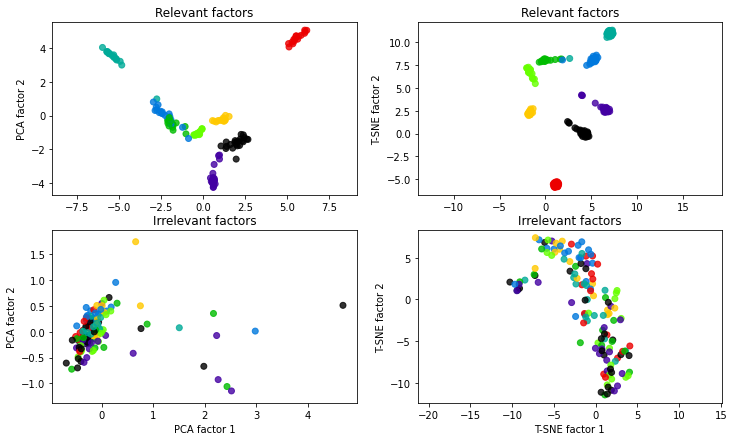

In [9]:
# latent variables

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

plt.figure(figsize=(12,7))
plt.subplot(221)
proj = PCA(n_components=2).fit_transform(mean_r)
plt.scatter(proj[:,0], proj[:,1], alpha=.8, color=direction_colors[direction_index_train])
plt.axis('equal')
plt.ylabel('PCA factor 2')
plt.title('Relevant factors')

plt.subplot(222)
ics_embedded = TSNE(n_components=2, n_jobs=2, random_state=12).fit_transform(mean_r)
plt.scatter(ics_embedded[:,0], ics_embedded[:,1], alpha=.8, color=direction_colors[direction_index_train])
plt.axis('equal')
plt.ylabel('T-SNE factor 2')
plt.title('Relevant factors')

plt.subplot(223)
proj = PCA(n_components=2).fit_transform(mean_i)
plt.scatter(proj[:,0], proj[:,1], alpha=.8, color=direction_colors[direction_index_train])
plt.axis('equal')
plt.xlabel('PCA factor 1')
plt.ylabel('PCA factor 2')
plt.title('Irrelevant factors')

plt.subplot(224)
ics_embedded = TSNE(n_components=2, n_jobs=2, random_state=12).fit_transform(mean_i)
plt.scatter(ics_embedded[:,0], ics_embedded[:,1], alpha=.8, color=direction_colors[direction_index_train])
plt.axis('equal')
plt.xlabel('T-SNE factor 1')
plt.ylabel('T-SNE factor 2')
plt.title('Irrelevant factors')

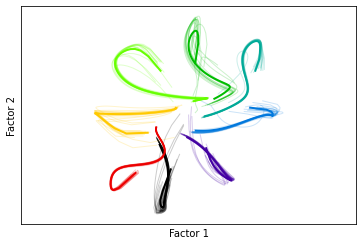

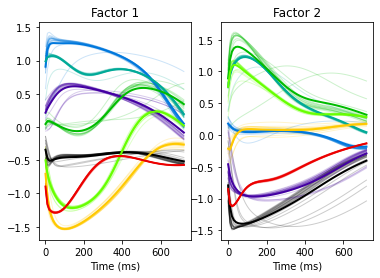

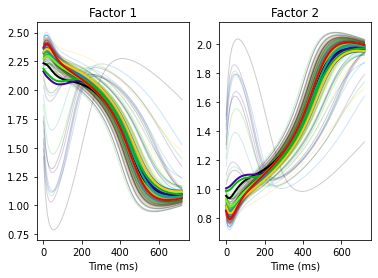

In [10]:
# latent factors
# relevant factors
plt.figure()
plot_all_2factors(z_r, direction_index_train)
# relevant factors
plt.figure()
plot_all_1factors(z_r, direction_index_train)
# irrelevant factors
plt.figure()
plot_all_1factors(z_i, direction_index_train)

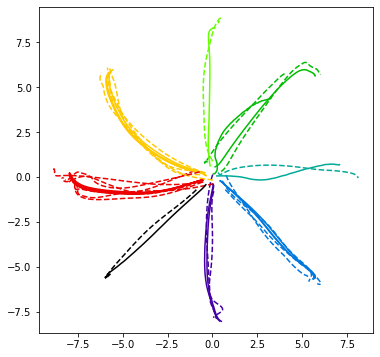

In [11]:
# behaviour reconstruction
plt.figure(figsize=(6,6));
plot_behaviour(b, behavioural_data, direction_index_train)

In [12]:
Xt = np.transpose(b, (0,2,1)).reshape((b.shape[0], -1))
yt = np.transpose(behavioural_data, (0,2,1)).reshape((behavioural_data.shape[0], -1))
print('R2 score behaviour: {:.3%}'.format(r2_score( yt, Xt)))

R2 score behaviour: 95.719%


## Test data

In [13]:
data = test_neural_data
test_sample_mode = 'posterior_sample' #choose 'mean' for previous behaviour
if test_sample_mode == 'mean':
    log_f_t, b_t, (g0_r_t, mean_r_t, logvar_r_t), (g0_r_t, mean_i_t, logvar_i_t), (z_r_t, z_i_t) = \
        model(data.astype('float'), training=False, test_sample_mode=test_sample_mode)
else:
    batch_size_eval = 128
    log_f_ts = []
    b_ts = []
    g0_r_ts, mean_r_ts, logvar_r_ts, z_r_ts = [], [], [], []
    g0_i_ts, mean_i_ts, logvar_i_ts, z_i_ts = [], [], [], []
    for neural_datum in data:
        neural_datum_batch = np.repeat(np.expand_dims(neural_datum, 0), batch_size_eval, axis=0)
        log_f_t, b_t, (g0_r_t, mean_r_t, logvar_r_t), (g0_i_t, mean_i_t, logvar_i_t), (z_r_t, z_i_t) = \
            model(neural_datum_batch.astype('float'), training=False, test_sample_mode=test_sample_mode)
        log_f_ts.append(np.mean(log_f_t, 0))
        b_ts.append(np.mean(b_t, 0))
        g0_r_ts.append(np.mean(g0_r_t, 0))
        mean_r_ts.append(np.mean(mean_r_t, 0))
        logvar_r_ts.append(np.mean(logvar_r_t, 0))
        z_r_ts.append(np.mean(z_r_t, 0))
        g0_i_ts.append(np.mean(g0_i_t, 0))
        mean_i_ts.append(np.mean(mean_i_t, 0))
        logvar_i_ts.append(np.mean(logvar_i_t, 0))
        z_i_ts.append(np.mean(z_i_t, 0))

    log_f_t = tf.stack(log_f_ts)
    b_t = tf.stack(b_ts)
    g0_r_t = tf.stack(g0_r_ts)
    mean_r_t = tf.stack(mean_r_ts)
    logvar_r_t = tf.stack(logvar_r_ts)
    z_r_t = tf.stack(z_r_ts)
    g0_i_t = tf.stack(g0_i_ts)
    mean_i_t = tf.stack(mean_i_ts)
    logvar_i_t = tf.stack(logvar_i_ts)
    z_i_t = tf.stack(z_i_ts)

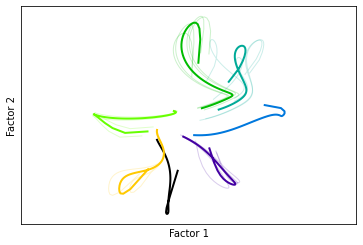

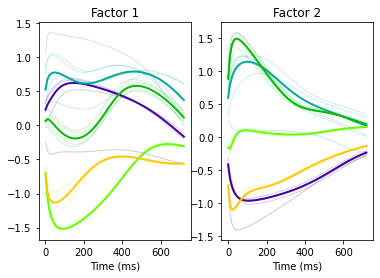

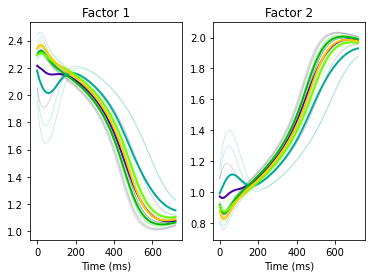

In [14]:
# relevant factors
plt.figure()
plot_all_2factors(z_r_t, direction_index_test)
# relevant factors
plt.figure()
plot_all_1factors(z_r_t, direction_index_test)
# irrelevant factors
plt.figure()
plot_all_1factors(z_i_t, direction_index_test)

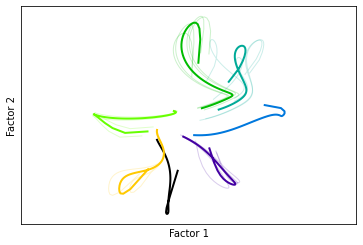

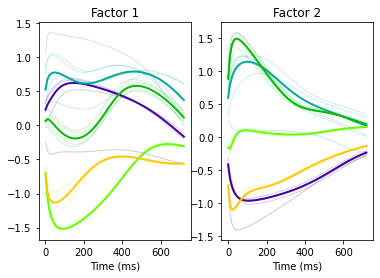

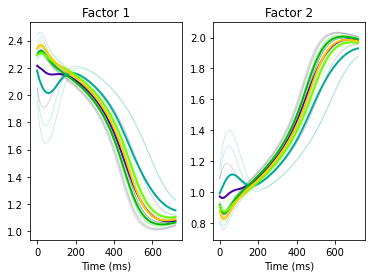

In [15]:
# relevant factors
plt.figure()
plot_all_2factors(z_r_t, direction_index_test)
# relevant factors
plt.figure()
plot_all_1factors(z_r_t, direction_index_test)
# irrelevant factors
plt.figure()
plot_all_1factors(z_i_t, direction_index_test)

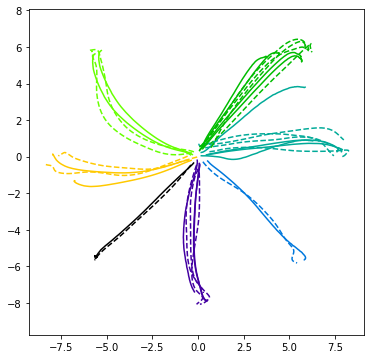

In [16]:
# behaviour reconstruction
plt.figure(figsize=(6,6));
plot_behaviour(b_t, test_behavioural_data, direction_index_test)

In [17]:
Xt = np.transpose(b_t, (0,2,1)).reshape((b_t.shape[0], -1))
yt = np.transpose(test_behavioural_data, (0,2,1)).reshape((test_behavioural_data.shape[0], -1))
print('R2 score behaviour: {:.3%}'.format(r2_score( yt, Xt)))

R2 score behaviour: 93.340%


# Trial-averaged firing rates and predictions
Computed from test+train data for better averages

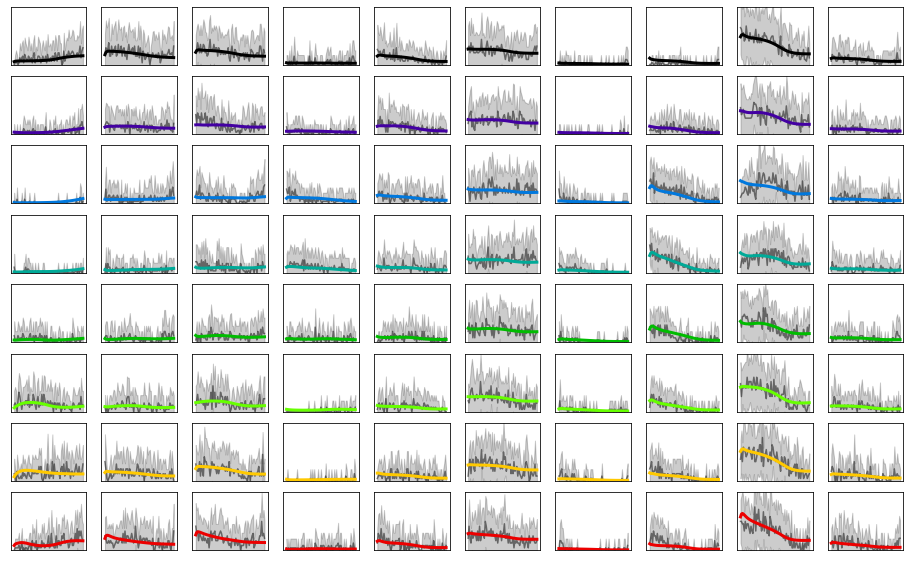

In [18]:
fig = plt.figure(figsize=(16,10))
colors = plt.cm.nipy_spectral(np.arange(8)/8)
for i in range(8):
    data = np.vstack((test_neural_data, neural_data))[direction_index_all==i,:,:]
    
    for i_n,n in enumerate(range(0,10)):
        ax = fig.add_subplot(8, 10, i*10+i_n+1)
        pred = np.vstack((np.exp(log_f_t)*settings['step'], np.exp(log_f)*settings['step']))[np.array(direction_index_all)==i,:,n]
        x = np.arange(data.shape[1])
        ax.plot(x,np.mean(data,axis=0)[:,n],'k',alpha=0.5);
        ax.fill_between(x,np.mean(data,axis=0)[:,n]-np.std(data,axis=0)[:,n], np.mean(data,axis=0)[:,n]+np.std(data,axis=0)[:,n], alpha=0.2, color='k');
        ax.plot(x,np.mean(pred,axis=0),lw=3, color=colors[i]);
        ax.set_xticks(())
        ax.set_yticks(())
        plt.ylim(0,1.5)

# Decoder weights

BehaviouralDense
2 2


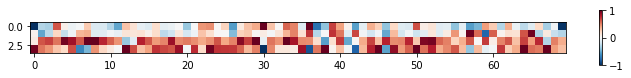

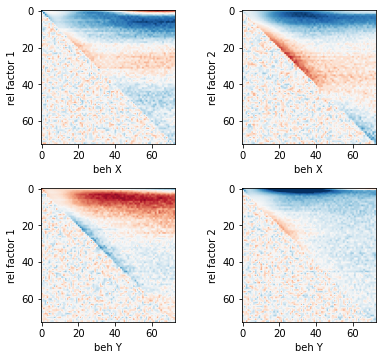

In [19]:
# neural decoder
plt.figure(figsize=(12,1))
plt.imshow((model.neural_dense._trainable_weights[0]),vmin=-1,vmax=1,cmap=plt.cm.RdBu_r)
plt.colorbar()
# behaviour decoder
plot_behaviour_weights(model)